# <center>TMVA Classification Using Deep Neural Networks</center>

In this notebook we still classify di-Higgs new data with Deep Neural Networks meethod.

In [28]:
import ROOT
from ROOT import TMVA, TTree
import pandas as pd

ROOT.TMVA.Tools.Instance()
## For PYMVA methods
TMVA.PyMethodBase.PyInitialize()

import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.models import Sequential
from keras.optimizers import Adam, SGD
#from keras.initializers import TruncatedNormal
#from keras import initializations
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
#from keras.callbacks import ReduceLROnPlateau

import itertools
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from array import array
import numpy as np

from root_numpy import root2array, tree2array

from IPython.display import Image, display

### Filter dataset by region.

This function will let you filter your dataset by region. It's known that SR_1tag is very signal poor, while SR_2tag has a lot a signal.

In [29]:
def filter_region(file, region, signal):
    oldfile = ROOT.TFile(file)
    oldtree = oldfile.Nominal
    signal_file = ROOT.TFile(region+"_"+signal+"_s.root","recreate")
    signal_tree = oldtree.CloneTree(0)
    backg_file = ROOT.TFile(region+"_"+signal+"_b.root","recreate")
    backg_tree = oldtree.CloneTree(0)
    data_file = ROOT.TFile(region+"_"+signal+"_d.root","recreate")
    data_tree = oldtree.CloneTree(0)
    for entry in oldtree:
        if (entry.m_region == region):
            if (entry.sample == "data"):
                data_tree.Fill()
            elif (entry.sample == "Xtohh1000"): #signal
                signal_tree.Fill()
            else:
                backg_tree.Fill()
    signal_tree.AutoSave()   
    backg_tree.AutoSave()
    data_tree.AutoSave()
    return signal_tree, signal_file, backg_tree, backg_file, data_tree, data_file

#Use as
#tree, file = filter_region("data.root", "SR_1tag", "small.root")

## Declare Factory and Input Data

data.root has unlabeled data points (called data) and fakes points. For the background training we'll use only the fakes points.

In [3]:
signal_tree, signal_file, backg_tree, backg_file, data_tree, data_file = filter_region("all_1000.root", "SR_1tag", "Xtohh1000")

outputFile = ROOT.TFile.Open("Higgs_ClassificationOutput.root", "RECREATE")

# Factory
factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification", outputFile,
                      "!V:ROC:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

#signal_tree.Print()

## Declare DataLoader(s)

The next step is to declare the DataLoader class that deals with input data abd variables 

We add first the signal and background trees in the data loader and then we
define the input variables that shall be used for the MVA training
note that you may also use variable expressions, which can be parsed by TTree::Draw( "expression" )]

We have two kinds of signals and for the training we have to use only one of them.

In [4]:
loader = ROOT.TMVA.DataLoader("dataset")

### global event weights per tree (see below for setting event-wise weights)
#signalWeight     = 1.0
#backgroundWeight = 1.0
   
### You can add an arbitrary number of signal or background trees
loader.AddSignalTree    ( signal_tree )
loader.AddBackgroundTree( backg_tree )
loader.SetWeightExpression("EventWeight")

not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']

## Define input variables 
for branch in backg_tree.GetListOfBranches():
    if branch.GetName() in not_cons:
        continue
    loader.AddVariable(branch.GetName())

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree Nominal of type Signal with 3553 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree Nominal of type Background with 9262 events


## Setup Dataset(s)

Setup the DataLoader by splitting events in training and test samples. 
Here we use a random split and a fixed number of training and test events.

In [5]:
## Apply additional cuts on the signal and background samples (can be different)
mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";

loader.PrepareTrainingAndTestTree(mycuts, mycutb,
                                  "nTrain_Signal=2000:nTrain_Background=2000:SplitMode=Random:"
                                   "NormMode=NumEvents:!V" )

## DNN

In [6]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

from keras.models import Sequential
from keras.optimizers import Adam, SGD
#from keras.initializers import TruncatedNormal
#from keras import initializations
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
#from keras.callbacks import ReduceLROnPlateau

In [7]:
# Define model
model = Sequential()
model.add(Dense(200, kernel_initializer='he_normal', activation='sigmoid', input_dim=10))
#model.add(Dropout(0.2))
model.add(Dense(200, kernel_initializer='he_normal', activation='softsign'))
#model.add(Dropout(0.2))
#model.add(Dense(64, kernel_initializer='glorot_normal', activation='relu'))
model.add(Dense(2, kernel_initializer='he_normal', activation='softmax'))

# Set loss and optimizer
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['binary_accuracy'])

# Store model to file
model.save('model_dense.h5')

# Print summary of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               2200      
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 402       
Total params: 83,002
Trainable params: 83,002
Non-trainable params: 0
_________________________________________________________________


In [8]:
factory.BookMethod(loader, ROOT.TMVA.Types.kPyKeras, 'Keras_Dense',
        'H:!V:VarTransform=N_AllClasses:FilenameModel=model_dense.h5:'+\
        'NumEpochs=200:BatchSize=32:TriesEarlyStopping=10')

<ROOT.TMVA::MethodPyKeras object ("Keras_Dense") at 0xa1b6d80>

Factory                  : Booking method: Keras_Dense
                         : 
Keras_Dense              : [dataset] : Create Transformation "N" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'm_FJpt' <---> Output : variable 'm_FJpt'
                         : Input : variable 'm_FJm' <---> Output : variable 'm_FJm'
                         : Input : variable 'm_DTpt' <---> Output : variable 'm_DTpt'
                         : Input : variable 'm_DTm' <---> Output : variable 'm_DTm'
                         : Input : variable 'm_dPhiFTwDT' <---> Output : variable 'm_dPhiFTwDT'
                         : Input : variable 'm_dRFJwDT' <---> Output : variable 'm_dRFJwDT'
                         : Input : variable 'm_dPhiDTwMET' <---> Output : variable 'm_dPhiDTwMET'
                         : Input : variable 'm_MET' <---> Output : variable 'm_MET'
                   

## Train, Test and Evaluate Model

In [ ]:
factory.TrainAllMethods()

# Here we test all methods using the test data set
factory.TestAllMethods()

# Here we evaluate all methods and compare their performances, computing efficiencies, 
# ROC curves etc.. using both training and tetsing data sets. Several histograms are 
# produced which can be examined with the TMVAGui or directly using the output file
factory.EvaluateAllMethods()

In [ ]:
imethod = factory.GetMethod("dataset", "Keras_Dense")
#TMVA::MethodBase * method = dynamic_cast<MethodBase *>(imethod);
icut = method.GetSignalReferenceCut()

## Plot ROC Curve
We enable JavaScript visualisation for the plots

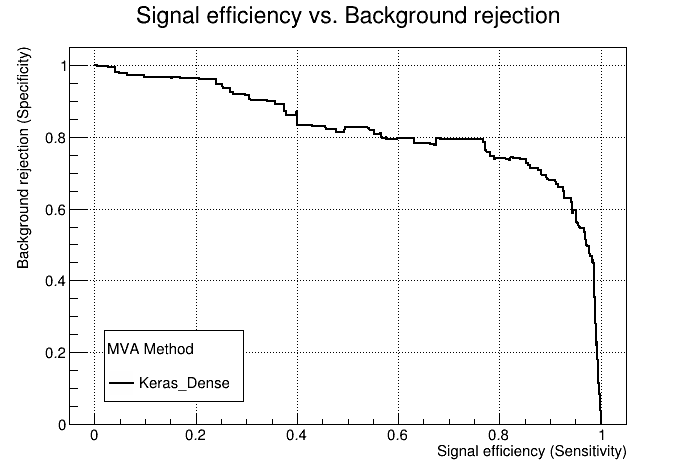

In [11]:
c1 = factory.GetROCCurve(loader)
c1.Draw()

## DNN Complete Function

In [30]:
def get_params(file):
    params = []
    first = 1
    with open(file, 'r') as fp:
        line = fp.readline().rstrip()
        while line:
            if (file.split('.')[1] == 'csv' and first):
                first = 0
                line = fp.readline().rstrip()
                continue
            params.append(line)
            line = fp.readline().rstrip()       
    return params

In [31]:
def DNN(params, training, model_input, comp_params, model_name, config, comb):
    
    output_file = config+ "_" + comb + "_DNN_Classification.root"
    signal_file = config+"_s.root"
    backg_file = config+"_b.root"
    
    signal_input = ROOT.TFile(signal_file)
    signal_tree = signal_input.Nominal
    
    backg_input = ROOT.TFile(backg_file)
    backg_tree = backg_input.Nominal
    
    outputFile = ROOT.TFile.Open(output_file, "RECREATE")

    # Factory
    factory = ROOT.TMVA.Factory("TMVA_Higgs_Classification_"+config+"_"+comb, outputFile,
                          "!V:ROC:Silent:Color:!DrawProgressBar:AnalysisType=Classification" )

    loader = ROOT.TMVA.DataLoader("dataset")

    ### global event weights per tree (see below for setting event-wise weights)
    #signalWeight     = 1.0
    #backgroundWeight = 1.0

    ### You can add an arbitrary number of signal or background trees
    loader.AddSignalTree    ( signal_tree )
    loader.AddBackgroundTree( backg_tree )
    loader.SetWeightExpression("EventWeight")
    
    not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']

    ## Define input variables 
    for branch in backg_tree.GetListOfBranches():
        if branch.GetName() in not_cons:
            continue
        loader.AddVariable(branch.GetName())
        
    mycuts = ROOT.TCut("")   ## for example: TCut mycuts = "abs(var1)<0.5 && abs(var2-0.5)<1";
    mycutb = ROOT.TCut("")   ## for example: TCut mycutb = "abs(var1)<0.5";


    loader.PrepareTrainingAndTestTree(mycuts, mycutb, training)
    
    # Model structure
    
    comp_params = comp_params.rstrip()
    comp_params = comp_params.split(',')
    loss = comp_params[0]
    
    comp_params.remove(loss)
    metrics = comp_params
    
    model = Sequential()
    model_input = model_input.rstrip()
    model_input = model_input.split(',')
    
    hidden_l = int(model_input[0])
    neurons = int(model_input[1])
    neurons_LF = int(model_input[2])
    k_init = model_input[3]
    activation_IL = model_input[4]
    activation_HL = model_input[5]
    activation_FL = model_input[6]
    
    print(type(neurons))
    
    model.add(Dense(neurons, kernel_initializer=k_init, activation=activation_IL, input_dim=10))
    for h in range(hidden_l):
        model.add(Dense(neurons, kernel_initializer=k_init, activation=activation_HL))
        
    model.add(Dense(neurons_LF, kernel_initializer=k_init, activation=activation_FL))
    
    # Set loss and optimizer
    model.compile(loss=loss, optimizer=Adam(), metrics=metrics)
    # Store model to file
    model.save(model_name)
    # Print summary of model
    model.summary()
    
    ## DNN method
    factory.BookMethod(loader,ROOT.TMVA.Types.kPyKeras, "Keras_Dense", params)
        
    factory.TrainAllMethods()
    
    factory.TestAllMethods()
    
    factory.EvaluateAllMethods()
    
    c1 = factory.GetROCCurve(loader)
    #c1.Draw()
    
    integ = factory.GetROCIntegral(loader, "Keras_Dense")
    
    imethod = factory.GetMethod("dataset", "Keras_Dense")
    #method = dynamic_cast<MethodBase *>(imethod);
    icut = imethod.GetSignalReferenceCut()
    print("cut:", icut)
    
    print("ROC integral:", integ)
    
    outputFile.Close()
    signal_input.Close()
    backg_input.Close()
    
    return integ

## Parameters Combination

In [32]:
def write_combs_params(file_params, file_training, file_model, comp_params, model_name, arr_NumEpochs, arr_BatchSize, arr_nTrain_Signal, arr_nTrain_Background, arr_number_HL, arr_neurons, arr_neurons_LF, arr_k_init, arr_activation_IL, arr_activation_HL, arr_activation_FL, arr_loss, arr_metrics):
    comb_params = list(itertools.product(arr_NumEpochs, arr_BatchSize, arr_nTrain_Signal, arr_nTrain_Background, arr_number_HL, arr_neurons, arr_neurons_LF, arr_k_init, arr_activation_IL, arr_activation_HL, arr_activation_FL, arr_loss, arr_metrics))
    with open(file_params, 'w') as params, open(file_training, 'w') as training, open(file_model, 'w') as model, open(comp_params, 'w') as comp_p:
        model.write("number_HL,neurons,neurons_LF,k_init,activation_IL,activation_HL,activation_FL\n")
        for cp in comb_params:
            string1 = "H:!V:VarTransform=N_AllClasses:FilenameModel="+model_name+":NumEpochs="+str(cp[0])+":BatchSize="+str(cp[1])+":TriesEarlyStopping=10\n"
            params.write(string1)
            string2 = "nTrain_Signal="+str(cp[2])+"%:nTrain_Background="+str(cp[3])+"%:SplitMode=Random:NormMode=NumEvents:!V\n"
            training.write(string2)
            string3 = str(cp[4])+','+str(cp[5])+','+str(cp[6])+','+str(cp[7])+','+str(cp[8])+','+str(cp[9])+','+str(cp[10])+'\n'
            model.write(string3)
            string4 = str(cp[11])+','+str(cp[12])+'\n'
            comp_p.write(string4)

In [33]:
file_params="dnn_params2.txt"
file_training="dnn_training2.txt"
file_model="dnn_model2.csv"
file_comp_params='comp_params.txt'
model_name="model_dense.h5"
arr_NumEpochs=[100]
arr_BatchSize=[64]
arr_nTrain_Signal=[80]
arr_nTrain_Background=[80]
arr_number_HL=[3]
arr_neurons=[100]
arr_neurons_LF=[2]
arr_k_init=['he_uniform']
arr_activation_IL=['relu']
arr_activation_HL=['selu']
arr_activation_FL=['softmax']
arr_loss=['poisson']
arr_metrics=['binary_crossentropy']

In [15]:
write_combs_params(file_params, file_training, file_model, file_comp_params, model_name, arr_NumEpochs, arr_BatchSize, arr_nTrain_Signal, arr_nTrain_Background, arr_number_HL, arr_neurons, arr_neurons_LF, arr_k_init, arr_activation_IL, arr_activation_HL, arr_activation_FL, arr_loss, arr_metrics)

## Hyperparameter Optimization

In [34]:
def param_opt(config, params, training, model, comp_params, model_name):
    max_roc = 0
    best_params = ""
    best_train = ""
    best_model = ""
    print(config)
    print("===============")
    for i in range(len(params)):
        roc = DNN(params[i], training[i], model[i], comp_params[i], model_name, config)
        print("i:",i)
        print("ROC:", roc)
        if roc > max_roc:
            max_roc = roc
            best_params = params[i]
            best_train = training[i]
            best_model = model[i]
            best_comp = comp_params[i]
    best_model = best_model.split(',')
    best_model_str = "numero_HL="+str(best_model[0])+", neurons="+str(best_model[1])+", neurons_LF="+str(best_model[2])+", k_init="+str(best_model[3])+", activation_IL="+str(best_model[4])+", activation_HL="+str(best_model[5])+", activation_FL="+str(best_model[6])
    best_comp = best_comp.split(',')
    best_comp_str = "loss="+best_comp[0]+", metrics="+best_comp[1]
    print("best parameters:", best_params)
    print("best training:", best_train)
    print("best model:", best_model_str)
    print("best comps:", best_comp_str)
    print("ROC integral:", max_roc)
    return

In [35]:
params_path = "dnn_params2.txt"
params = get_params(params_path)
training_path = "dnn_training2.txt"
training = get_params(training_path)
configs = ["PreSel_0tag_Xtohh1000", "PreSel_1tag_Xtohh1000", "PreSel_2tag_Xtohh1000", 
           "QCDCR_0tag_Xtohh1000", "QCDCR_1tag_Xtohh1000", "QCDCR_2tag_Xtohh1000",
           "SR_0tag_Xtohh1000", "SR_1tag_Xtohh1000", "SR_2tag_Xtohh1000",
           "PreSel_0tag_Xtohh2000", "PreSel_1tag_Xtohh2000", "PreSel_2tag_Xtohh2000",
           "QCDCR_0tag_Xtohh2000", "QCDCR_1tag_Xtohh2000", "QCDCR_2tag_Xtohh2000",
           "SR_0tag_Xtohh2000", "SR_1tag_Xtohh2000", "SR_2tag_Xtohh2000"]
s_end = "_s.root"
b_end = "_b.root"
comp_params_path = "comp_params.txt"
comp_params = get_params(comp_params_path)
model_input_path = "dnn_model2.csv"
model_input = get_params(model_input_path)
model_name = "model_dense.h5"

In [27]:
params_ = "H:!V:VarTransform=N_AllClasses:FilenameModel=model_dense.h5:NumEpochs=300:BatchSize=64:TriesEarlyStopping=10"
model_input_ = "3,20,2,he_uniform,relu,elu,softmax"
comp_params_ = "binary_crossentropy,binary_accuracy"
training_ = "nTrain_Signal=8014:nTrain_Background=351:SplitMode=Random:NormMode=NumEvents:!V"
model_name_ = "model_dense.h5"
comb = "COMB5"
DNN(params_, training_, model_input_, comp_params_, model_name_, configs[17], comb)

<class 'int'>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 20)                220       
_________________________________________________________________
dense_24 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_25 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_26 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_27 (Dense)             (None, 2)                 42        
Total params: 1,522
Trainable params: 1,522
Non-trainable params: 0
_________________________________________________________________
Train on 8365 samples, validate on 3523 samples
Epoch 1/300
8365/8365 [==============================] - 3s 302us/step - loss:

0.9416964464904529

                         : 
                         : Evaluation results ranked by best signal efficiency and purity (area)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet       MVA                       
                         : Name:         Method:          ROC-integ
                         : dataset       Keras_Dense    : 0.942
                         : -------------------------------------------------------------------------------------------------------------------
                         : 
                         : Testing efficiency compared to training efficiency (overtraining check)
                         : -------------------------------------------------------------------------------------------------------------------
                         : DataSet              MVA              Signal efficiency: from test sample (from training sam

Warning in <TCanvas::Constructor>: Deleting canvas with same name: ROCCurve dataset class 0


In [13]:
#param_opt(configs[17], params, training, model_input, comp_params, model_name)

# Prediction

In [36]:
# Add weights
def v_out(tree, not_cons, variables, reader):
    
    h = ROOT.TH1D("","",60,-1,1)
    
    nevt = tree.GetEntries()

    vout = np.arange(nevt, dtype='float').reshape(1, nevt)

    for ievt, entry in enumerate(tree):
        i = 0    
        for branch in tree.GetListOfBranches():
            name = branch.GetName()
            if name in not_cons:
                continue
            variables[i][0] = getattr(entry,name)
            i += 1

        vout[0,ievt] = reader.EvaluateMVA(methodName)
        h.Fill(vout[0,ievt])
    
    return h, vout, variables

In [37]:
def gen_report_pred(background, signal, data, sep):
    background = list(background[0])
    signal = list(signal[0])
    data = list(data[0])
    bakg_t = [0]*len(background)
    signal_t = [1]*len(signal)
    y_predicted = background + signal
    y_test = bakg_t + signal_t
    for i in range(len(y_predicted)):
        if (y_predicted[i] < sep):
            y_predicted[i] = 0
        else:
            y_predicted[i] = 1
    for j in range(len(data)):
        if (data[j] < sep):
            data[j] = 0
        else:
            data[j] = 1
    print(classification_report(y_test, y_predicted, target_names=["background", "signal"]))
    print("Accuracy total:", accuracy_score(y_test, y_predicted))
    #print("Confusion matrix:", confusion_matrix(y_test, data))
    return data

In [38]:
def predict(config, type_signal, methodName, sep, comb):
    reader = TMVA.Reader( "!Color:!Silent" )
    
    dataPath = config + "_" + type_signal + "_d.root"
    bkgPath = config + "_" + type_signal + "_b.root"
    sigPath = config + "_" + type_signal + "_s.root"
    
    print(dataPath)
    
    dataFile = ROOT.TFile(dataPath)
    bkgFile = ROOT.TFile(bkgPath)
    sigFile = ROOT.TFile(sigPath)

    dataTree = dataFile.Nominal
    bkgTree = bkgFile.Nominal
    sigTree = sigFile.Nominal
    
    # Add Variables: We add variables to the reader exactly in the same way we did for the **DataLoader** during the training
    # We need to specify the address of the variable in order to pass it to TMVA when we iterate on the TTree
    variables = []
    i = 0
    
    not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']
    
    for branch in dataTree.GetListOfBranches():
        if branch.GetName() in not_cons:
            continue
        aux = array('f',[0])
        variables.append(aux)
        reader.AddVariable(branch.GetName(),variables[i])
        i = i+1
    
    # Setup Classifiers: We set up the classifiers by reading the input weights from the appropriate files
    # The file is stored for example as *dataset/weights/TMVAClassification_BDT.weights.xml
    weightfile = "dataset/weights/TMVA_Higgs_Classification_"+ config + "_" + type_signal + "_" + comb + "_" + methodName + ".weights.xml" #_" + config + "_" + type_signal + "_" + comb + "_" + methodName + "
    name = ROOT.TString(methodName)
    reader.BookMVA( name, weightfile )
    
    # We iterate on the input event in the given TTree. We provide as input first the background tree 
    # We return the output results for the various methods in big numpy array [ number of methods x 
    # number of events]
    # We also fill an histogram for each method.
    # Note that is important to fill the arrays with the tree entries in order to pass the values to 
    # the TMVA::Reader
    variables2 = variables
    
    hd, d_vout, variables = v_out(dataTree, not_cons, variables, reader)
    hs, s_vout, variables = v_out(sigTree, not_cons, variables, reader)
    hb, b_vout, variables = v_out(bkgTree, not_cons, variables, reader)
    
    print("Signal size:", len(s_vout[0]))
    print("Background size:", len(b_vout[0]))
    
    # Classification report
    prediction = gen_report_pred(b_vout, s_vout, d_vout, sep)
    
    print("Prediction size:", len(prediction))
    
    # Histogram
    c1 = ROOT.TCanvas("c1", "c1")
    c1.cd()
    hb.Draw()
    hs.SetLineColor(ROOT.kRed)
    hd.SetFillColor(ROOT.kGreen)
    hb.SetFillColor(ROOT.kBlue)
    hb.Draw()
    hs.Draw('Same')
    hd.Draw('Same')
    hb.SetTitle("background")
    hs.SetTitle("signal")
    hd.SetTitle("data")
    c1.BuildLegend()
        
    img_file = config + "_" + type_signal + "_" + comb + "_" + methodName + "_hist.png"
    c1.SaveAs(img_file)
    
    dataFile.Close()
    sigFile.Close()
    bkgFile.Close()
    
    display(Image(filename=img_file)) 
    
    return prediction, d_vout[0]

In [39]:
import struct

def predict_test(config, type_signal, methodName, sep, comb):
    
    reader = TMVA.Reader( "!Color:!Silent" )
    data_input = config + "_" + type_signal + "_" + comb + "_DNN_Classification.root"
    data = ROOT.TFile(data_input)
    testTree = data.Get("dataset/TestTree")
    
    array_ = tree2array(testTree)
    className = pd.DataFrame(array_)
    className = className['className']
    true = []
    
    for el in className:
        if el == b'Background':
            true.append(0)
        else:
            true.append(1)
    
    variables = []
    i = 0
    
    not_cons = ['classID', 'className', 'weight', 'Keras_Dense']
    
    for branch in testTree.GetListOfBranches():
        if branch.GetName() in not_cons:
            continue
        aux = array('f',[0])
        variables.append(aux)
        reader.AddVariable(branch.GetName(),variables[i])
        i = i+1
    
    weightfile = "dataset/weights/TMVA_Higgs_Classification_"+ config + "_" + type_signal + "_" + comb + "_" + methodName + ".weights.xml" #_" + config + "_" + type_signal + "_" + comb + "_" + methodName + "
    name = ROOT.TString(methodName)
    reader.BookMVA( name, weightfile )
    
    ht, t_vout, variables = v_out(testTree, not_cons, variables, reader)
    
    pred = []
    for el in t_vout[0]:
        if el <= sep:
            pred.append(0)
        else:
            pred.append(1)
    
    print("Test set size:", len(t_vout[0]))

    print(classification_report(true, pred))
    print("Accuracy:", accuracy_score(true, pred))
    matrix = confusion_matrix(true, pred)
    print("Confusion matrix:")
    print(matrix[0])
    print(matrix[1]) 
    

SR_2tag_Xtohh2000_d.root
Signal size: 11449
Background size: 439
             precision    recall  f1-score   support

 background       0.23      0.79      0.35       439
     signal       0.99      0.90      0.94     11449

avg / total       0.96      0.89      0.92     11888

Accuracy total: 0.8924966352624495
Prediction size: 1


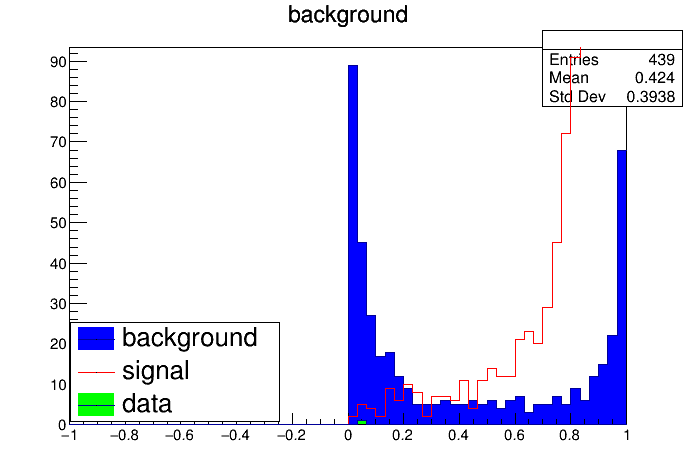

Info in <TCanvas::Print>: png file SR_2tag_Xtohh2000_COMB5_Keras_Dense_hist.png has been created


In [50]:
config = "SR_2tag"
type_signal = "Xtohh2000"
methodName = "Keras_Dense"
sep = 0.934
comb = "COMB5"
pred, score = predict(config, type_signal, methodName, sep, comb)

In [52]:
print(score)

[0.05173677]


In [51]:
import matplotlib.pyplot as plt

score_s = [i for i in score if i > 0.934]
score_b = [i for i in score if i <= 0.934]

plt.figure(figsize=[10,8])
plt.hist([score_s, score_b], color=['green', 'red'], bins=30)
plt.xlabel("DNN Score", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title('Real Data Prediction with DNN in '+config+"_"+type_signal, fontsize=20)
plt.savefig(config+"_"+type_signal+"_DNN_pred.png")
plt.show()

<Figure size 1000x800 with 1 Axes>